In [1]:
import subprocess
import os
from datetime import datetime
import copy

from scipy import stats
import pandas as pd
import numpy as np
import urllib2

from matplotlib import pyplot as plt
from sklearn import feature_extraction

from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import MiniBatchKMeans, DBSCAN
from sklearn.neighbors import KDTree

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline



/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
attr_dict = {'AF': 'authors', 'PY': 'year','TI': 'title', 'SO': 'journal', 'DE': 'keywords', 'AB': 'abstract', 'TC': 'citations'}
type_dict = {'AF': list(), 'PY': int, 'TI': str, 'SO': str, 'DE': list(), 'AB': str, 'TC': int}
seps_dict = {'AF': None, 'PY': None,'TI': None, 'SO': None, 'DE': ';', 'AB': None, 'TC': None}

def parse_attributes(article_text):
    record = {}
    n = 0
    authors = []
    for row in article_text.splitlines():
        attr = row[:2] if row[:2] != '  ' else attr
        
        if attr == 'AF':
            authors += [row[3:]]

        if attr != 'AF':        
            if attr not in attr_dict.keys():
                continue
            record[attr] = row[3:]
    record['AF'] = authors
    return record

def compile_articles_list(articles_dir='inputs'):
    articles_list = list()
    for fname in os.listdir(articles_dir):
        with open(os.path.join(articles_dir, fname), 'r') as f:
            text = f.read()
        text = text.split('\n\n')
        for article_entry in text:
            parsed_entry = parse_attributes(article_entry)
            if len(parsed_entry.keys()) < len(attr_dict.keys()):
                pass
            else:
                if len(articles_list) == 0:
                    rm_authors = 0
                else:
                    rm_authors = len(articles_list[-1]['AF'])
                parsed_entry['AF'] = parsed_entry['AF'][rm_authors:]
                articles_list += [parsed_entry,]
                
    return articles_list

articles_list = compile_articles_list(articles_dir='inputs')


In [5]:

def vectorize_abstracts(articles, patents):
    num_articles = len(articles)
    if not hasattr(patents, '__iter__'):
        patents = [patents,]

    articles.extend(patents)
    hasher = HashingVectorizer(lowercase=True,
                           stop_words='english', non_negative=True,
                           norm=None, binary=False)

    vectorizer = make_pipeline(hasher, TfidfTransformer())
    X = vectorizer.fit_transform(articles)

    return X[:num_articles,:], X[num_articles:,:]

def do_clustering(X, y, use_algorithm='dbscan'):
    def use_kmeans(X, y):
        km = MiniBatchKMeans(n_clusters=5, init='k-means++', n_init=1,
                            init_size=1000, batch_size=5)
        km.fit(X)
        y_hat = km.predict(y)
        return y_hat, km.labels_

    def use_dbscan(X, y):
        eps_vals = np.logspace(-2,2,200)
        best_n = 0
        use_eps = 0
        for eps in eps_vals:
            db = DBSCAN(eps=eps, min_samples=2)
            db.fit(X)
            n_clusters = len(set(db.labels_))
            if n_clusters > best_n:
                use_eps = eps
                best_n = n_clusters
                result = db
            else:
                pass
            
        db = DBSCAN(eps=use_eps, min_samples=2)
        y_hat = db.fit_predict(X, y)
        print y.shape, y_hat, X.shape
        return y_hat, db.labels_
    
    if use_algorithm == 'kmeans':
        return use_kmeans(X,y)
    elif use_algorithm == 'dbscan':
        return use_dbscan(X,y)


In [35]:
articles_dir = 'vesta'
articles_list = compile_articles_list(articles_dir=articles_dir)

## Uncomment to add clustering by patent abstract contents
# patent_abstract = "A battery pack thermal management system for use in an electric car. The battery pack thermal management system includes a plurality of thermistors connected to a plurality of cells of a battery pack. A battery monitor board is connected to the thermistors. The system also includes a manifold and a plurality of cooling tubes connected to the manifold. A tube seal plug is arranged over an end of the cooling tube and an end fitting is arranged on an end of the cooling tube. The thermal management system will cool the battery pack to predetermined temperatures to increase the longevity of the battery pack within the electric vehicle."
# article_abstracts = [a['AB'] for a in articles_list]
# authors_list = list(set([a for alist in articles_list for a in alist['AF']]))

# X,y = vectorize_abstracts(article_abstracts, patent_abstract)
# y_hat, clusters = do_clustering(X, y, use_algorithm='kmeans')

minyear = datetime.now().year - 10
use_articles = [a for i, a in enumerate(articles_list) if int(a['PY']) >= minyear]# and clusters[i]==y_hat]

authors_list = []
for article in use_articles:
    if int(article['PY']) < datetime.now().year-10:
        pass
    else:
        authors_list += article['AF']
authors_list = list(set(authors_list))

In [36]:
# 
len(use_articles), len(authors_list)

(490, 1311)

In [37]:

papers = pd.DataFrame(data=0, index=authors_list, columns=range(datetime.now().year-10, datetime.now().year+1))
citations = pd.DataFrame(data=0, index=authors_list, columns=range(datetime.now().year-10, datetime.now().year+1))

for i, article in enumerate(use_articles):
    if int(article['PY']) < datetime.now().year-10:
        continue
    papers[int(article['PY'])].ix[list(article['AF'])] += 1
    citations[int(article['PY'])].ix[list(article['AF'])] += int(article['TC'])

## Uncomment to add google scholar query that eliminates authors likely beyond a postdoc
# old_authors = []
# for author in papers.index:
#     old_pubs = os.system('python scholar.py -c 1 --author "%s" --before %i'%(author.lower(), datetime.now().year-10))
#     if old_pubs > 0:
#         old_authors.append(author)
        
# papers = papers.drop(old_authors)
# citations = citations.drop(old_authors)
# print len(papers)

papers.to_csv('tesla_papers.csv')
citations.to_csv('tesla_citations.csv')





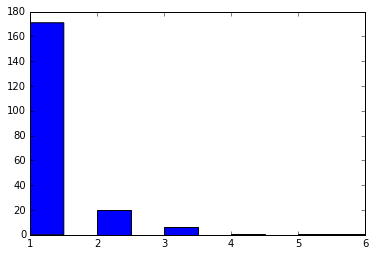

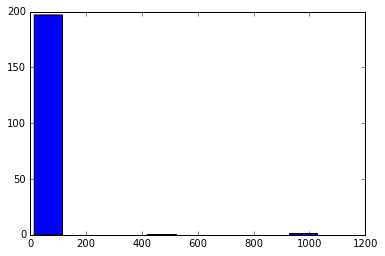

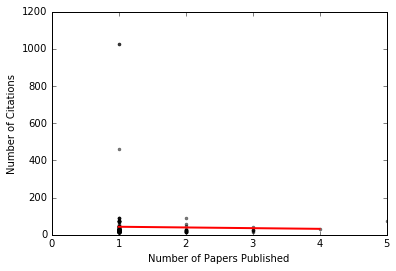

In [41]:

top_authors = citations.sum(axis=1).nlargest(200).index

_papers = papers.ix[top_authors].sum(axis=1)
_citations = citations.ix[top_authors].sum(axis=1)

fig ,ax = plt.subplots()
ax.hist(_papers)
plt.show()


fig ,ax = plt.subplots()
ax.hist(_citations)
plt.show()

fig, ax = plt.subplots()
ax.plot(_papers, _citations, marker='.', color='k', ls=' ' ,alpha=0.5)
ax.set_xlim((0,5))

out = stats.linregress(_papers, _citations)
ax.plot(range(1,5), np.arange(1,5,1)*out[0]+out[1], 'r', lw=2)
ax.set_xlabel('Number of Papers Published')
ax.set_ylabel('Number of Citations')

plt.show()